### Import Dependencies

In [1]:
import numpy as np
import utils
import code_HGN_test
import code_QGN_test
from os.path import isfile, exists
import preprocess4HGN
import preprocess4QGN
import matplotlib.pyplot as plt 

print 'Load needed things!'

Load needed things!


### Load w2v model :  it downloads if that doesn't exist.

In [2]:
w2v_path = './data/GoogleNews-vectors-negative300.bin'
w2v_model = utils.load_w2v(w2v_path)

Start loading Google Word2Vec data
Finished loading Google Word2Vec data



### Load preproceeded data

In [3]:
if isfile('./data/preprocessed4HGN.npz') == False:
    preprocess4HGN.preprocess()    
if isfile('./data/preprocessed4QGN.npz') == False:
    preprocess4QGN.preprocess()
    
npzfile = np.load('./data/preprocessed4HGN.npz')
img_idx = npzfile['arr_0']
text_inputs = npzfile['arr_2']

npzfile = np.load('./data/preprocessed4QGN.npz')
reverse_label = npzfile['arr_6']

num_data = img_idx.shape[0]
dim_sentence = text_inputs.shape[1]
max_step_sentence = text_inputs.shape[2]
num_label = len(reverse_label)

print 'End loading MetaData'

End loading MetaData


### Define Model: Run this cell only once per one kernel

In [4]:
result_heatmap, ph_image, ph_sen_HGN, \
ph_sen_len_HGN, ph_dropout= code_HGN_test.define_model(dim_sentence, 
                                                   max_step_sentence, 
                                                   num_hg_Depth = 4,
                                                   dim_hg_feat = 256,
                                                   dim_rnn_cell = 256)

question_logits, ph_combine, ph_sen_QGN, \
ph_sen_len_QGN, ph_keepprob = code_QGN_test.define_model(dim_sentence,
                                                    max_step_sentence,
                                                    dim_rnn_cell = 256,
                                                    num_label = num_label)

RNN ENCODER CREATED
Fused Model Created
=======VGG NET with RNN=======


### Get test image index. Refer the printed result when you check the result from the test data

In [5]:
idx_test, idx_train = utils.get_test_idx(img_idx, num_data)

Test image index : [127 422  15 390  19 235 138 338  31 318 378 270 465 277  26  76 124 195
 111 445 367 189  66]


### Choose the image for the test

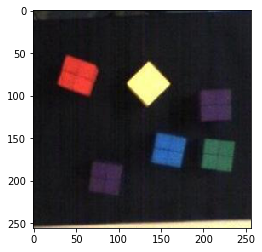

In [17]:
test_img_idx =195
img_path = './data/train_img'
curr_HGN_test_img = utils.load_test_img(img_path, test_img_idx, img_resize=256, plot_flag = 1)
curr_QGN_test_img = utils.load_test_img(img_path, test_img_idx, img_resize=64, plot_flag = 0)

### HGN: set the test input script

In [25]:
init_command = "pick up the black block"
init_embed_input, init_seq_len = utils.load_test_script(init_command, w2v_model, 
                                                        dim_sentence, max_step_sentence)   

Ready the test input script


### HGN: Run the result

INFO:tensorflow:Restoring parameters from ./HGN_model/model.ckpt-300


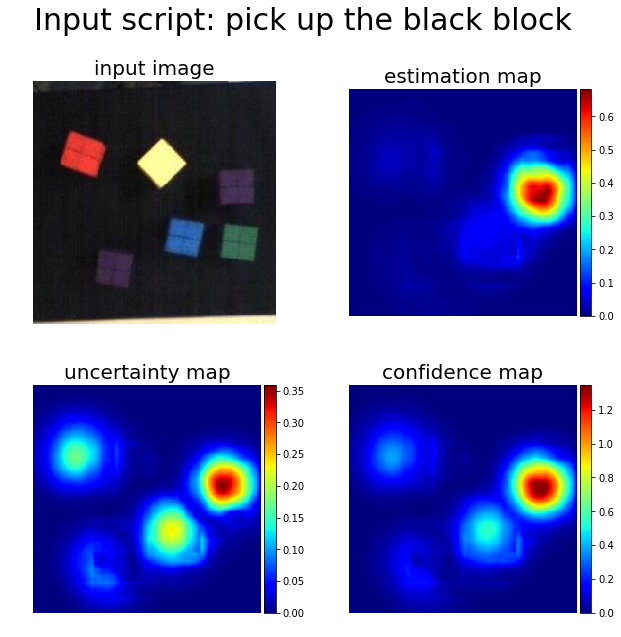

In [26]:
mean_of_esti, uncertainty = code_HGN_test.session_run(result_heatmap, ph_image, ph_sen_HGN, 
                                                      ph_sen_len_HGN, ph_dropout,
                                                      restore_path = "./HGN_model/model.ckpt-300",
                                                      curr_embed_input = init_embed_input,
                                                      curr_seq_len = init_seq_len,
                                                      curr_test_img = curr_HGN_test_img)
utils.plot_HGN_result(init_command, curr_HGN_test_img, mean_of_esti, uncertainty, bound_u=-1)

### QGN: Prepare the inputs

In [23]:
from skimage.transform import resize

curr_combine_map = np.zeros((1, 64, 64, 4))

curr_esti = resize(mean_of_esti, [64, 64], preserve_range=True)
curr_uncertainty = resize(uncertainty, [64, 64], preserve_range=True)
curr_upperbound = curr_esti + 2 * curr_uncertainty
curr_combine_map[0, :, :, 0:3] = curr_QGN_test_img
curr_combine_map[0, :, :, 3] = curr_upperbound

question_logit = code_QGN_test.session_run(question_logits, ph_combine, ph_sen_QGN,
                                           ph_sen_len_QGN, ph_keepprob,
                                           restore_path='./QGN_model/model.ckpt-1000',
                                           curr_combine_map = curr_combine_map,
                                           curr_embed_input = init_embed_input,
                                           curr_seq_len = init_seq_len)

INFO:tensorflow:Restoring parameters from ./QGN_model/model.ckpt-1000


### Start Interaction : answer to the question!

[['yellow' 'red' 'blue' 'left' 'right' 'purple' 'green' 'middle' 'upper'
  'lower' 'lower right' 'upper right' 'upper left' 'lower left' 'this']]
[[  5.43008864e-01   4.50782120e-01   4.28007031e-03   6.42444065e-04
    6.08366972e-04   4.16054740e-04   1.76664878e-04   5.15094398e-05
    2.44164330e-05   8.25935513e-06   3.17706849e-07   2.94529343e-07
    2.92343231e-07   2.63041272e-07   5.50040014e-08]]


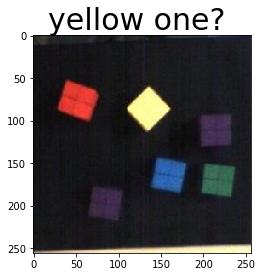

KeyboardInterrupt: 

In [24]:
sorted_idx = np.argsort(-question_logit)
print reverse_label[sorted_idx]
print -np.sort(-question_logit)
plt.imshow(curr_HGN_test_img[0, :, :, :])
plt.suptitle('%s one?'% reverse_label[sorted_idx[0][0]], size = 30)

if reverse_label[sorted_idx[0][0]] == 'this':
    reshape_esti = resize(mean_of_esti, [256, 256], preserve_range=True)
    max_pos = np.unravel_index(reshape_esti.argmax(), reshape_esti.shape)
    plt.scatter(max_pos[1], max_pos[0], s=100, c='cyan', marker='x')
plt.show()

curr_answer = raw_input('Answer to the question! : ')

### HQN : Get Better Result

Ready the test input script
INFO:tensorflow:Restoring parameters from ./HGN_model/model.ckpt-300


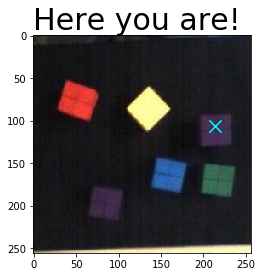

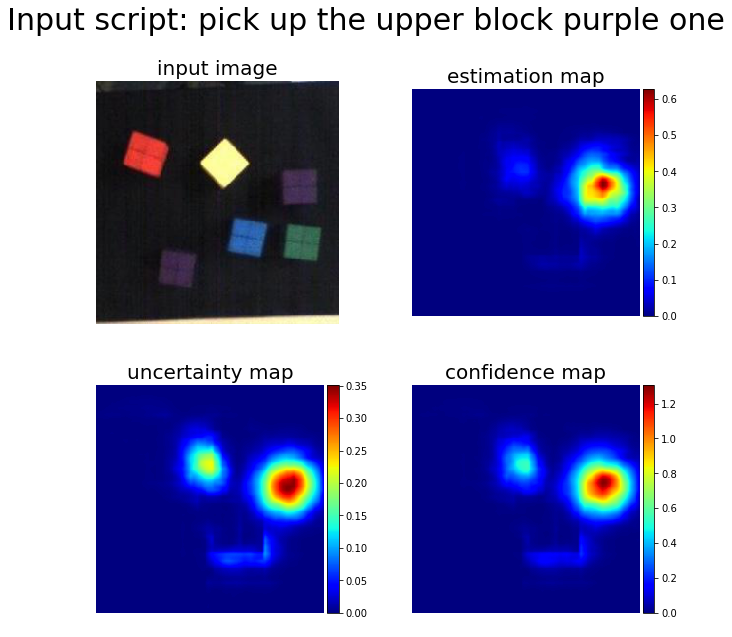

In [22]:
if 'yes' in curr_answer:
    if reverse_label[sorted_idx[0][0]] == 'this':
        after_command = init_command
    else:
        after_command = init_command + ' ' + reverse_label[sorted_idx[0][0]]
else:
    after_command = init_command + ' ' + curr_answer

after_embed_input, after_seq_len = utils.load_test_script(after_command, w2v_model, 
                                                          dim_sentence, max_step_sentence)
    
after_esti, after_uncertainty = code_HGN_test.session_run(result_heatmap, ph_image, ph_sen_HGN, 
                                                      ph_sen_len_HGN, ph_dropout,
                                                      restore_path = "./HGN_model/model.ckpt-300",
                                                      curr_embed_input = after_embed_input,
                                                      curr_seq_len = after_seq_len,
                                                      curr_test_img = curr_HGN_test_img)
plt.imshow(curr_HGN_test_img[0, :, :, :])
plt.suptitle('Here you are!', size = 30)

resize_after_esti = resize(after_esti, [256, 256], preserve_range=True)

after_max_pos = np.unravel_index(resize_after_esti.argmax(), resize_after_esti.shape)
plt.scatter(after_max_pos[1], after_max_pos[0], s=150, c='cyan', marker='x')
    
utils.plot_HGN_result(after_command, curr_HGN_test_img, after_esti, after_uncertainty)